# Furniture Price Prediction 🛋️

## 🎯 Objective
Predict furniture prices based on product characteristics and analyze key price drivers.

## 📊 Dataset
The dataset is an educational dataset based on real-world furniture product data.  
It contains 3,694 observations and 14 features.

The target variable is `price`, expressed in US dollars.

The dataset includes both categorical and numerical features.  
Key categorical features include product category and designer, while numerical features describe physical dimensions such as depth, height, and width.

The data contains missing values and price outliers, requiring cleaning and preprocessing before modeling.  
The dataset is provided as a single CSV file.

In [53]:
import sys
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu, ttest_ind, fisher_exact, chi2_contingency, shapiro

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd


sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [54]:
file_name = "ikea.csv"

In [55]:
try:
    if not os.path.exists("ikea.csv"):
        url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv"
        response = requests.get(url)
        if response.status_code == 200:
            text_data = response.text
            with open(file_name, "w", encoding="utf-8") as f:
                f.write(text_data)
except Exception as e:
    print(f"Error: {e}")

In [56]:
df = pd.read_csv(file_name)

In [57]:
df.head()

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


## 🧐 EDA

In [58]:
df.shape

(3694, 14)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3694 non-null   int64  
 1   item_id            3694 non-null   int64  
 2   name               3694 non-null   object 
 3   category           3694 non-null   object 
 4   price              3694 non-null   float64
 5   old_price          3694 non-null   object 
 6   sellable_online    3694 non-null   bool   
 7   link               3694 non-null   object 
 8   other_colors       3694 non-null   object 
 9   short_description  3694 non-null   object 
 10  designer           3694 non-null   object 
 11  depth              2231 non-null   float64
 12  height             2706 non-null   float64
 13  width              3105 non-null   float64
dtypes: bool(1), float64(4), int64(2), object(7)
memory usage: 378.9+ KB


In [60]:
df.isna().sum()

Unnamed: 0              0
item_id                 0
name                    0
category                0
price                   0
old_price               0
sellable_online         0
link                    0
other_colors            0
short_description       0
designer                0
depth                1463
height                988
width                 589
dtype: int64

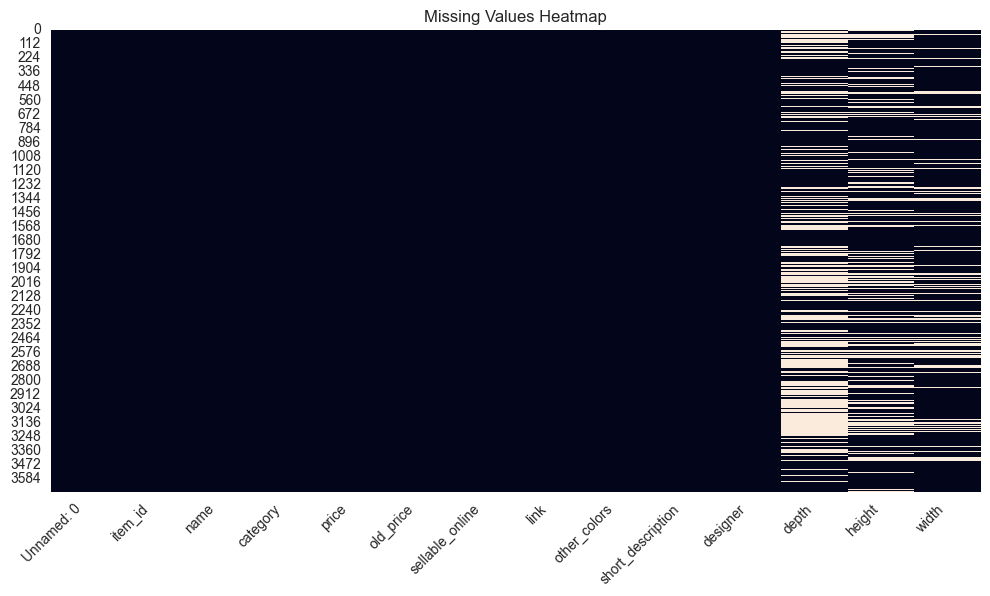

In [61]:
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.xticks(rotation=45,ha="right")
plt.show()

In [62]:
df.describe()

,Unnamed: 0,item_id,price,depth,height,width
count,3694.000000,3.694000e+03,3694.000000,2231.000000,2706.000000,3105.000000
mean,1846.500000,4.863240e+07,1078.208419,54.379202,101.679970,104.470853
std,1066.510275,2.888709e+07,1374.652494,29.958351,61.097585,71.133771
min,0.000000,5.848700e+04,3.000000,1.000000,1.000000,1.000000
25%,923.250000,2.039057e+07,180.900000,38.000000,67.000000,60.000000
50%,1846.500000,4.928808e+07,544.700000,47.000000,83.000000,80.000000
75%,2769.750000,7.040357e+07,1429.500000,60.000000,124.000000,140.000000
max,3693.000000,9.993262e+07,9585.000000,257.000000,700.000000,420.000000


❗️The mean and median of the `price` column differ noticeably, suggesting outliers in the right tail of the distribution.

In [63]:
#CV (coefficient of variation) = σ / mean
1374.652494/1078.208419

1.2749413469382305

⭕️ CV > 0.3 indicates high variability and a wide dispersion of the data.

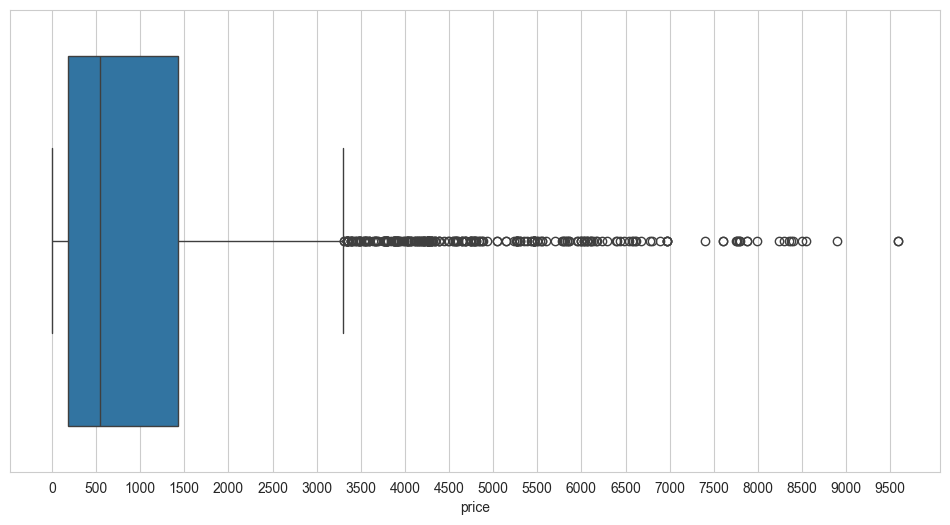

In [64]:
sns.boxplot(x=df.price)
plt.xticks(range(0, 10000, 500))
plt.show()

In [65]:
df[df["price"] >= 7000]

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
118,118,89186778,KONGSFJORD,Beds,8551.0,"SR 8,735",True,https://www.ikea.com/sa/en/p/kongsfjord-divan-...,Yes,"Divan bed, 180x200 cm",Ola Wihlborg/IKEA of Sweden/Synnöve Mork,NaN,135.0,180.0
146,146,99278070,VALLENTUNA,Beds,7796.0,"SR 9,745",True,https://www.ikea.com/sa/en/p/vallentuna-4-seat...,Yes,4-seat modular sofa w 3 sofa-beds,Fredriksson/L Löwenhielm/Hilland/IKEA of Sweden,NaN,84.0,346.0
179,179,49278591,GRÖNLID,Beds,7610.0,No old price,True,https://www.ikea.com/sa/en/p/groenlid-corner-s...,Yes,"Corner sofa-bed, 5-seat",Francis Cayouette/Ehlén Johansson/IKEA of Sweden,164.0,104.0,252.0
190,190,29277639,LIDHULT,Beds,9585.0,No old price,True,https://www.ikea.com/sa/en/p/lidhult-corner-so...,Yes,"Corner sofa-bed, 6-seat",Henrik Preutz/IKEA of Sweden,164.0,102.0,387.0
205,205,79186774,KONGSFJORD,Beds,8356.0,"SR 8,540",True,https://www.ikea.com/sa/en/p/kongsfjord-divan-...,Yes,"Divan bed, 180x200 cm",Ola Wihlborg/Synnöve Mork/IKEA of Sweden,NaN,135.0,180.0
214,214,29266184,LIDHULT,Beds,7785.0,No old price,True,https://www.ikea.com/sa/en/p/lidhult-corner-so...,Yes,"Corner sofa-bed, 5-seat",IKEA of Sweden/Henrik Preutz,98.0,102.0,294.0
238,238,19299726,VIMLE,Beds,7765.0,No old price,True,https://www.ikea.com/sa/en/p/vimle-corner-sofa...,Yes,"Corner sofa-bed, 5-seat",Ehlén Johansson/IKEA of Sweden,98.0,83.0,349.0
251,251,59266074,LIDHULT,Beds,7873.0,"SR 9,430",True,https://www.ikea.com/sa/en/p/lidhult-3-seat-so...,No,3-seat sofa-bed,Henrik Preutz/IKEA of Sweden,164.0,102.0,298.0
2289,2289,59193723,KIVIK,Sofas & armchairs,8295.0,No old price,True,https://www.ikea.com/sa/en/p/kivik-u-shaped-so...,Yes,"U-shaped sofa, 7-seat",Ola Wihlborg,257.0,83.0,368.0
2344,2344,79277632,LIDHULT,Sofas & armchairs,9585.0,No old price,True,https://www.ikea.com/sa/en/p/lidhult-corner-so...,Yes,"Corner sofa-bed, 6-seat",Henrik Preutz/IKEA of Sweden,164.0,102.0,387.0


💰 Prices for such products can indeed be this high, so they should not be considered anomalies.

In [66]:
df.describe(include="object")

,name,category,old_price,link,other_colors,short_description,designer
count,3694,3694,3694,3694,3694,3694,3694
unique,607,17,365,2962,2,1706,381
top,BESTÅ,Tables & desks,No old price,https://www.ikea.com/sa/en/p/norraker-norraker...,No,Chair,IKEA of Sweden
freq,173,612,3040,4,2182,59,828


In [67]:
df.nunique()

Unnamed: 0           3694
item_id              2962
name                  607
category               17
price                 979
old_price             365
sellable_online         2
link                 2962
other_colors            2
short_description    1706
designer              381
depth                 114
height                193
width                 263
dtype: int64

🧹 The "Unnamed: 0" column contains index values and does not provide useful information, so it is removed.

In [68]:
df = df.drop(columns="Unnamed: 0")

👯‍♂️ Handling duplicates in the "item_id" column


In [69]:
counts = df.item_id.value_counts()
dupes = counts[counts > 1]
dupes

item_id
79241940    4
30247378    3
347888      3
60323592    3
20273141    3
           ..
69281804    2
69286806    2
50171122    2
70441769    2
30306495    2
Name: count, Length: 620, dtype: int64

❓Are these duplicates true duplicates?

1. Check for completely duplicated rows  
2. Check for rows that match in all columns except "category"  
3. Compare the shapes of "dupes_not_cat and "dupes"

In [70]:
all_dupes = df[df.duplicated(subset=df, keep=False)]
all_dupes

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width


In [71]:
cols_to_check = [c for c in df.columns if c != "category"]
dupes_not_cat = df[df.duplicated(subset=cols_to_check, keep=False)]
dupes_not_cat

,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0
5,10122647,INGOLF,Bar furniture,345.0,No old price,True,https://www.ikea.com/sa/en/p/ingolf-bar-stool-...,No,"Bar stool with backrest, 63 cm",Carina Bengs,45.0,91.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,90421911,BRYGGJA,Wardrobes,597.0,SR 995,True,https://www.ikea.com/sa/en/p/bryggja-storage-u...,No,"Storage unit, 120x173 cm",Ola Wihlborg,43.0,173.0,120.0
3572,9157261,ELVARLI,Wardrobes,440.0,SR 540,True,https://www.ikea.com/sa/en/p/elvarli-1-section...,No,"1 section, 52x36x222-350 cm",Ehlén Johansson,35.0,NaN,51.0
3628,99188003,ELVARLI,Wardrobes,2377.0,"SR 3,025",True,https://www.ikea.com/sa/en/p/elvarli-4-section...,No,"4 sections, 262x36x222-350 cm",Ehlén Johansson,35.0,NaN,261.0
3676,59315159,ELVARLI,Wardrobes,2397.0,"SR 2,945",True,https://www.ikea.com/sa/en/p/elvarli-3-section...,No,"3 sections, 258x51x222-350 cm",Ehlén Johansson,51.0,NaN,258.0


In [72]:
dupes_not_cat.shape

(1352, 13)

In [73]:
dupes.sum()

np.int64(1352)

🚮 All "dupes" are true duplicates and will be removed.

In [74]:
df = df.drop_duplicates(subset=cols_to_check, keep="first").reset_index(drop=True)

In [75]:
df.shape

(2962, 13)

🚮 Removing other columns that do not carry meaningful information: "link", "item_id"

In [76]:
df = df.drop(columns=["link", "item_id"])
df.head()

,name,category,price,old_price,sellable_online,other_colors,short_description,designer,depth,height,width
0,FREKVENS,Bar furniture,265.0,No old price,True,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,NORDVIKEN,Bar furniture,995.0,No old price,False,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,STIG,Bar furniture,69.0,No old price,True,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,NORBERG,Bar furniture,225.0,No old price,True,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


🧽 Cleaning the "designer" column

In [77]:
df.head(50).designer.unique()

array(['Nicholai Wiig Hansen', 'Francis Cayouette', 'Henrik Preutz',
       'Marcus Arvonen', 'Carina Bengs', 'K Hagberg/M Hagberg',
       'Sarah Fager', 'Ehlén Johansson', 'Nike Karlsson',
       'Maja Ganszyniec', 'Karl Malmvall',
       'John/Jonas/Petrus/Paul/Caroline', 'Nike Karlsson/Maja Ganszyniec',
       'J Karlsson/N Karlsson', 'IKEA of Sweden/Karl Malmvall',
       'IKEA of Sweden', 'Nike Karlsson/J Karlsson/N Karlsson',
       'Ola Wihlborg', 'IKEA of Sweden/Tina Christensen',
       'IKEA of Sweden/K Hagberg/M Hagberg'], dtype=object)

In [78]:
df.designer.nunique()

381

📝 Create a function to clean and alphabetically sort designer names in each entry

In [79]:
def cleanDesigners(value, removeIKEA=False, emptyValue=np.nan):
    if not isinstance(value, str):
        return value

    if len(value) > 0 and value[0].isdigit():
        return emptyValue

    designers = value.split("/")

    if removeIKEA:
        try:
            designers.remove("IKEA of Sweden")
        except: 
            pass

    if len(designers) > 0:
        return "/".join(sorted(designers))
    else:
        return emptyValue

In [80]:
df["designer_clean"] = df["designer"].apply(cleanDesigners, args=(False, "IKEA of Sweden"))

In [81]:
df = df.drop(columns="designer")
df.head()

,name,category,price,old_price,sellable_online,other_colors,short_description,depth,height,width,designer_clean
0,FREKVENS,Bar furniture,265.0,No old price,True,No,"Bar table, in/outdoor, 51x51 cm",NaN,99.0,51.0,Nicholai Wiig Hansen
1,NORDVIKEN,Bar furniture,995.0,No old price,False,No,"Bar table, 140x80 cm",NaN,105.0,80.0,Francis Cayouette
2,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,No,Bar table and 4 bar stools,NaN,NaN,NaN,Francis Cayouette
3,STIG,Bar furniture,69.0,No old price,True,Yes,"Bar stool with backrest, 74 cm",50.0,100.0,60.0,Henrik Preutz
4,NORBERG,Bar furniture,225.0,No old price,True,No,"Wall-mounted drop-leaf table, ...",60.0,43.0,74.0,Marcus Arvonen


In [82]:
df.shape

(2962, 11)

In [83]:
df.designer_clean.value_counts()

designer_clean
IKEA of Sweden                              785
Ehlén Johansson/IKEA of Sweden              138
Ehlén Johansson                             136
Francis Cayouette                           131
Ola Wihlborg                                128
                                           ... 
Chris Martin/IKEA of Sweden/Mia Lagerman      1
Ehlén Johansson/Karl Malmvall                 1
J Löfgren/J Pettersson/Marcus Arvonen         1
Eva Schildt                                   1
Lars Norinder                                 1
Name: count, Length: 199, dtype: int64

In [84]:
df.head(50).designer_clean.unique()

array(['Nicholai Wiig Hansen', 'Francis Cayouette', 'Henrik Preutz',
       'Marcus Arvonen', 'Carina Bengs', 'K Hagberg/M Hagberg',
       'Sarah Fager', 'Ehlén Johansson', 'Nike Karlsson',
       'Maja Ganszyniec', 'Karl Malmvall',
       'Caroline/John/Jonas/Paul/Petrus', 'Maja Ganszyniec/Nike Karlsson',
       'J Karlsson/N Karlsson', 'IKEA of Sweden/Karl Malmvall',
       'IKEA of Sweden', 'J Karlsson/N Karlsson/Nike Karlsson',
       'Ola Wihlborg', 'IKEA of Sweden/Tina Christensen',
       'IKEA of Sweden/K Hagberg/M Hagberg'], dtype=object)

👉 Replace missing values in "width", "height", and "depth" with category-wise medians

In [85]:
cols_to_fill = ["width", "height", "depth"]

for col in cols_to_fill:
    df[col] = df.groupby("category")[col].transform(lambda x: x.fillna(x.median()))

🧽 Cleaning the "old_price" column

In [86]:
df["old_price"].unique()

array(['No old price', 'SR 2,375', 'SR 295', 'SR 175', 'SR 995',
       'SR 1,385', 'SR 445', 'SR 925', 'SR 2,205', 'SR 895', 'SR 2,435',
       'SR 125', 'SR 1,595', 'SR 2,880', 'SR 940', 'SR 800', 'SR 1,995',
       'SR 3,245', 'SR 8,735', 'SR 2,310', 'SR 2,560', 'SR 3,760',
       'SR 3,130', 'SR 9,745', 'SR 1,885', 'SR 3,265', 'SR 50/4 pack',
       'SR 1,450', 'SR 250', 'SR 1,590', 'SR 2,360', 'SR 4,040',
       'SR 1,715', 'SR 2,100', 'SR 2,395', 'SR 1,250', 'SR 5,610',
       'SR 7,225', 'SR 2,795', 'SR 8,540', 'SR 1,950', 'SR 5,400',
       'SR 375', 'SR 5,045', 'SR 5,640', 'SR 3,665', 'SR 2,095',
       'SR 2,495', 'SR 9,430', 'SR 6,530', 'SR 138', 'SR 350', 'SR 1,023',
       'SR 437', 'SR 1,390', 'SR 50', 'SR 595', 'SR 275', 'SR 395',
       'SR 26', 'SR 695', 'SR 645', 'SR 649', 'SR 232', 'SR 750', 'SR 30',
       'SR 892', 'SR 10', 'SR 490', 'SR 4,185', 'SR 655', 'SR 27',
       'SR 455', 'SR 7', 'SR 657', 'SR 1,120', 'SR 237', 'SR 22',
       'SR 1,180', 'SR 15', 'SR 10/4

In [87]:
df.tail()

,name,category,price,old_price,sellable_online,other_colors,short_description,depth,height,width,designer_clean
2957,PAX / MEHAMN/AULI,Wardrobes,2045.0,No old price,True,No,"Wardrobe combination, 200x66x...",66.0,236.0,200.0,Ehlén Johansson/IKEA of Sweden
2958,ELVARLI,Wardrobes,750.0,SR 820,True,No,"1 section, 92x51x222-350 cm",50.0,236.0,91.0,Ehlén Johansson
2959,ELVARLI,Wardrobes,1572.0,"SR 1,755",True,No,"2 sections, 135x51x222-350 cm",50.0,236.0,135.0,Ehlén Johansson
2960,ELVARLI,Wardrobes,924.0,"SR 1,050",True,No,"2 sections, 175x51x222-350 cm",50.0,236.0,175.0,Ehlén Johansson
2961,ELVARLI,Wardrobes,2745.0,"SR 3,130",True,No,"3 sections, 178x51x222-350 cm",50.0,236.0,178.0,Ehlén Johansson


🤔 Comparing "price" and "old_price" shows that "old_price" is higher, which is unlikely in real-world IKEA pricing.  
The currency is likely Saudi Riyal (SR), so instead of just removing "SR", the values need to be converted to US dollars.

In [88]:
df.old_price.value_counts()

old_price
No old price    2388
SR 595            10
SR 995             7
SR 275             7
SR 475             6
                ... 
SR 699             1
SR 3,250           1
SR 349             1
SR 4,445           1
SR 1,050           1
Name: count, Length: 365, dtype: int64

🛑 There are many "No old price" values. They could be imputed using the "price" column (observing that "old_price" is roughly one-third of "price"), but doing so would make the feature unsuitable for ML, as it would essentially be generated data. 

In [89]:
df.old_price.replace("No old price", np.nan, inplace=True)
df.old_price = df.old_price.str[3:]
df.tail()

/var/folders/j7/7h_cjxwd53bgn6302v2jdgh80000gn/T/ipykernel_67241/4053518906.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.old_price.replace("No old price", np.nan, inplace=True)


,name,category,price,old_price,sellable_online,other_colors,short_description,depth,height,width,designer_clean
2957,PAX / MEHAMN/AULI,Wardrobes,2045.0,NaN,True,No,"Wardrobe combination, 200x66x...",66.0,236.0,200.0,Ehlén Johansson/IKEA of Sweden
2958,ELVARLI,Wardrobes,750.0,820,True,No,"1 section, 92x51x222-350 cm",50.0,236.0,91.0,Ehlén Johansson
2959,ELVARLI,Wardrobes,1572.0,"1,755",True,No,"2 sections, 135x51x222-350 cm",50.0,236.0,135.0,Ehlén Johansson
2960,ELVARLI,Wardrobes,924.0,"1,050",True,No,"2 sections, 175x51x222-350 cm",50.0,236.0,175.0,Ehlén Johansson
2961,ELVARLI,Wardrobes,2745.0,"3,130",True,No,"3 sections, 178x51x222-350 cm",50.0,236.0,178.0,Ehlén Johansson


In [90]:
df["old_price"] = df.old_price.apply(
    lambda x: str(x).replace(",", "") if isinstance(x, str) else x)
df.tail()

,name,category,price,old_price,sellable_online,other_colors,short_description,depth,height,width,designer_clean
2957,PAX / MEHAMN/AULI,Wardrobes,2045.0,NaN,True,No,"Wardrobe combination, 200x66x...",66.0,236.0,200.0,Ehlén Johansson/IKEA of Sweden
2958,ELVARLI,Wardrobes,750.0,820,True,No,"1 section, 92x51x222-350 cm",50.0,236.0,91.0,Ehlén Johansson
2959,ELVARLI,Wardrobes,1572.0,1755,True,No,"2 sections, 135x51x222-350 cm",50.0,236.0,135.0,Ehlén Johansson
2960,ELVARLI,Wardrobes,924.0,1050,True,No,"2 sections, 175x51x222-350 cm",50.0,236.0,175.0,Ehlén Johansson
2961,ELVARLI,Wardrobes,2745.0,3130,True,No,"3 sections, 178x51x222-350 cm",50.0,236.0,178.0,Ehlén Johansson


In [91]:
df.old_price = pd.to_numeric(df.old_price, errors="coerce")
df.old_price.dtype

dtype('float64')

In [92]:
exchange_rate = 0.27
df["old_price_usd"] = df["old_price"] * exchange_rate
df.drop(columns="old_price", inplace=True)
df.tail()

,name,category,price,sellable_online,other_colors,short_description,depth,height,width,designer_clean,old_price_usd
2957,PAX / MEHAMN/AULI,Wardrobes,2045.0,True,No,"Wardrobe combination, 200x66x...",66.0,236.0,200.0,Ehlén Johansson/IKEA of Sweden,NaN
2958,ELVARLI,Wardrobes,750.0,True,No,"1 section, 92x51x222-350 cm",50.0,236.0,91.0,Ehlén Johansson,221.40
2959,ELVARLI,Wardrobes,1572.0,True,No,"2 sections, 135x51x222-350 cm",50.0,236.0,135.0,Ehlén Johansson,473.85
2960,ELVARLI,Wardrobes,924.0,True,No,"2 sections, 175x51x222-350 cm",50.0,236.0,175.0,Ehlén Johansson,283.50
2961,ELVARLI,Wardrobes,2745.0,True,No,"3 sections, 178x51x222-350 cm",50.0,236.0,178.0,Ehlén Johansson,845.10


In [93]:
df["price_coef"] = df["price"] / df["old_price_usd"]
df.tail()

,name,category,price,sellable_online,other_colors,short_description,depth,height,width,designer_clean,old_price_usd,price_coef
2957,PAX / MEHAMN/AULI,Wardrobes,2045.0,True,No,"Wardrobe combination, 200x66x...",66.0,236.0,200.0,Ehlén Johansson/IKEA of Sweden,NaN,NaN
2958,ELVARLI,Wardrobes,750.0,True,No,"1 section, 92x51x222-350 cm",50.0,236.0,91.0,Ehlén Johansson,221.40,3.387534
2959,ELVARLI,Wardrobes,1572.0,True,No,"2 sections, 135x51x222-350 cm",50.0,236.0,135.0,Ehlén Johansson,473.85,3.317506
2960,ELVARLI,Wardrobes,924.0,True,No,"2 sections, 175x51x222-350 cm",50.0,236.0,175.0,Ehlén Johansson,283.50,3.259259
2961,ELVARLI,Wardrobes,2745.0,True,No,"3 sections, 178x51x222-350 cm",50.0,236.0,178.0,Ehlén Johansson,845.10,3.248136


In [94]:
mean_coef = df.price_coef.mean()
mean_coef

np.float64(3.007593018949936)

In [95]:
df["old_price_usd"] = df.old_price_usd.fillna(df.price/mean_coef)
df.tail()

,name,category,price,sellable_online,other_colors,short_description,depth,height,width,designer_clean,old_price_usd,price_coef
2957,PAX / MEHAMN/AULI,Wardrobes,2045.0,True,No,"Wardrobe combination, 200x66x...",66.0,236.0,200.0,Ehlén Johansson/IKEA of Sweden,679.94572,NaN
2958,ELVARLI,Wardrobes,750.0,True,No,"1 section, 92x51x222-350 cm",50.0,236.0,91.0,Ehlén Johansson,221.40000,3.387534
2959,ELVARLI,Wardrobes,1572.0,True,No,"2 sections, 135x51x222-350 cm",50.0,236.0,135.0,Ehlén Johansson,473.85000,3.317506
2960,ELVARLI,Wardrobes,924.0,True,No,"2 sections, 175x51x222-350 cm",50.0,236.0,175.0,Ehlén Johansson,283.50000,3.259259
2961,ELVARLI,Wardrobes,2745.0,True,No,"3 sections, 178x51x222-350 cm",50.0,236.0,178.0,Ehlén Johansson,845.10000,3.248136


In [96]:
df.drop(columns="price_coef", inplace=True)
df

,name,category,price,sellable_online,other_colors,short_description,depth,height,width,designer_clean,old_price_usd
0,FREKVENS,Bar furniture,265.0,True,No,"Bar table, in/outdoor, 51x51 cm",47.0,99.0,51.0,Nicholai Wiig Hansen,88.110326
1,NORDVIKEN,Bar furniture,995.0,False,No,"Bar table, 140x80 cm",47.0,105.0,80.0,Francis Cayouette,330.829336
2,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,False,No,Bar table and 4 bar stools,47.0,102.0,48.0,Francis Cayouette,696.570309
3,STIG,Bar furniture,69.0,True,Yes,"Bar stool with backrest, 74 cm",50.0,100.0,60.0,Henrik Preutz,22.941934
4,NORBERG,Bar furniture,225.0,True,No,"Wall-mounted drop-leaf table, ...",60.0,43.0,74.0,Marcus Arvonen,74.810654
...,...,...,...,...,...,...,...,...,...,...,...
2957,PAX / MEHAMN/AULI,Wardrobes,2045.0,True,No,"Wardrobe combination, 200x66x...",66.0,236.0,200.0,Ehlén Johansson/IKEA of Sweden,679.945720
2958,ELVARLI,Wardrobes,750.0,True,No,"1 section, 92x51x222-350 cm",50.0,236.0,91.0,Ehlén Johansson,221.400000
2959,ELVARLI,Wardrobes,1572.0,True,No,"2 sections, 135x51x222-350 cm",50.0,236.0,135.0,Ehlén Johansson,473.850000
2960,ELVARLI,Wardrobes,924.0,True,No,"2 sections, 175x51x222-350 cm",50.0,236.0,175.0,Ehlén Johansson,283.500000


🔍 Checking values in categorical columns

In [97]:
for c in df.columns:
    s = set(df[c])
    if len(s) <= 17:
        print(f"{c}: {s}\n")

category: {'Beds', 'Outdoor furniture', 'Sofas & armchairs', 'Bookcases & shelving units', 'Chairs', 'Room dividers', 'Wardrobes', 'Cabinets & cupboards', 'Café furniture', 'Bar furniture', 'Chests of drawers & drawer units', 'Nursery furniture', 'Trolleys', 'Tables & desks', "Children's furniture", 'TV & media furniture', 'Sideboards, buffets & console tables'}

sellable_online: {False, True}

other_colors: {'No', 'Yes'}



✅ The values are valid and the columns are clean.

❓What is the distribution of categories in these columns?

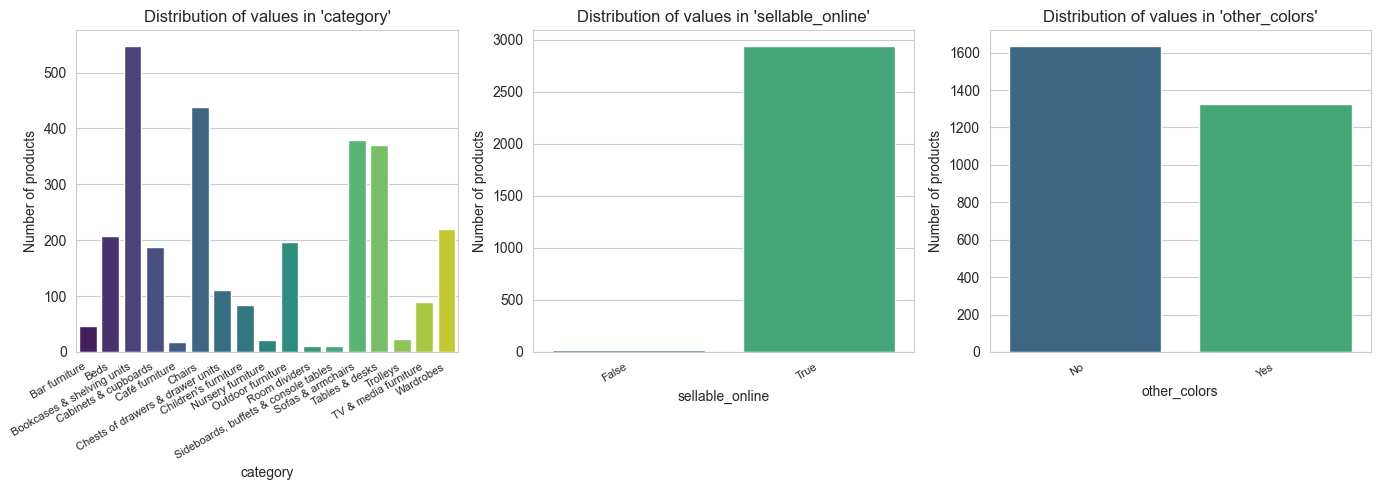

In [98]:
cat_cols = ["category", "sellable_online", "other_colors"]

plt.figure(figsize=(14, 5))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df, x=col, hue=col, legend=False, palette="viridis")
    plt.title(f"Distribution of values in '{col}'")
    plt.xlabel(col)
    plt.ylabel("Number of products")
    plt.xticks(rotation=30, ha='right', fontsize=8)
    
plt.tight_layout()
plt.show()

📊 The `category` column shows a highly uneven distribution.  
No hypothesis is formed for `sellable_online`.  
The distribution for `other_colors` is much more uniform.

## 👩‍🎨 Visualization of statistics

In [99]:
df_new = df.copy()

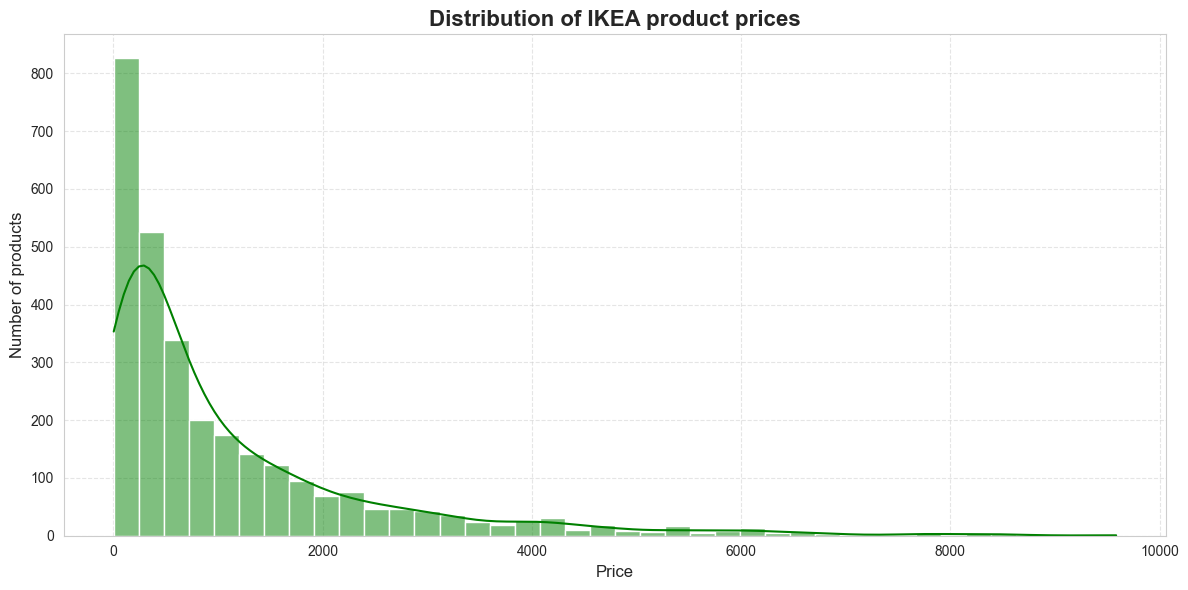

In [100]:
sns.histplot(df_new.price, kde=True, color="green", bins=40)
plt.title("Distribution of IKEA product prices", fontsize=16, fontweight="bold")
plt.xlabel("Price", fontsize=12)
plt.ylabel("Number of products", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

✅ The distribution of `price` is not normal and can be log-transformed.

In [101]:
df_new.head()

,name,category,price,sellable_online,other_colors,short_description,depth,height,width,designer_clean,old_price_usd
0,FREKVENS,Bar furniture,265.0,True,No,"Bar table, in/outdoor, 51x51 cm",47.0,99.0,51.0,Nicholai Wiig Hansen,88.110326
1,NORDVIKEN,Bar furniture,995.0,False,No,"Bar table, 140x80 cm",47.0,105.0,80.0,Francis Cayouette,330.829336
2,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,False,No,Bar table and 4 bar stools,47.0,102.0,48.0,Francis Cayouette,696.570309
3,STIG,Bar furniture,69.0,True,Yes,"Bar stool with backrest, 74 cm",50.0,100.0,60.0,Henrik Preutz,22.941934
4,NORBERG,Bar furniture,225.0,True,No,"Wall-mounted drop-leaf table, ...",60.0,43.0,74.0,Marcus Arvonen,74.810654


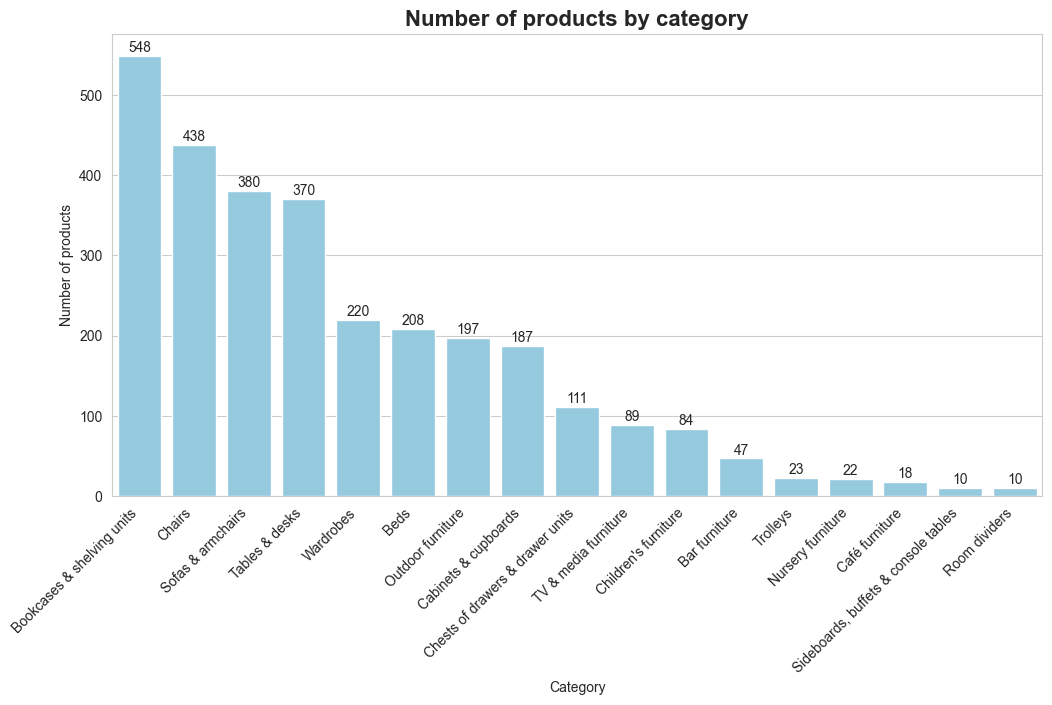

In [102]:
product_count = df_new["category"].value_counts()
sns.barplot(x=product_count.index, y=product_count.values, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Number of products by category", fontsize=16, fontweight="bold")
plt.ylabel("Number of products")
plt.xlabel("Category")

for i, count in enumerate(product_count.values):
    plt.text(i, count + 5, str(count), ha='center', fontsize=10)
    
plt.show()

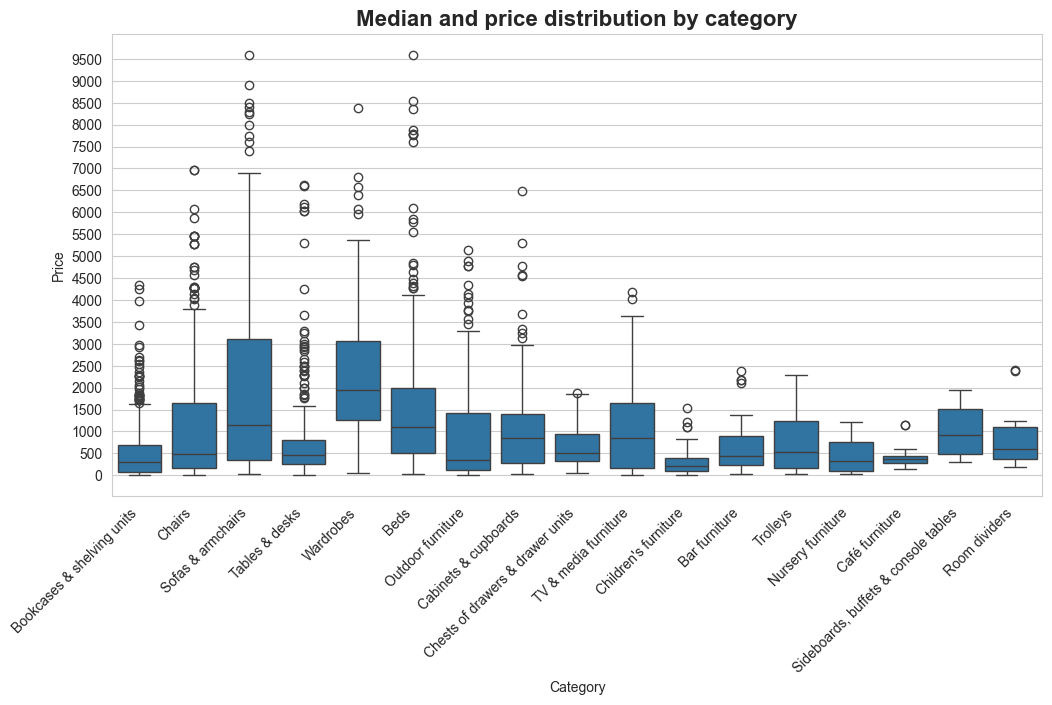

In [103]:
cat_order = df_new['category'].value_counts().index

# Building a boxplot with ordered categories

sns.boxplot(data=df_new, x="category", y="price", order=cat_order)
plt.xticks(rotation=45, ha="right")
plt.yticks(range(0, 10000, 500))
plt.ylabel("Price")
plt.xlabel("Category")
plt.title("Median and price distribution by category", fontsize=16, fontweight="bold")
plt.show()

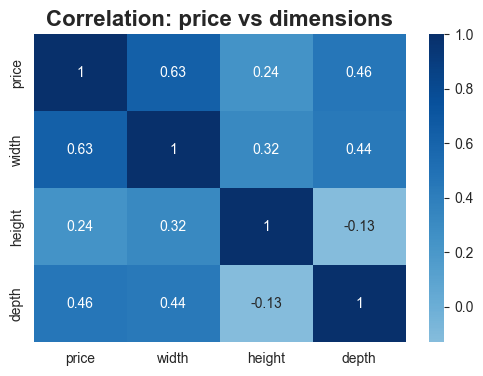

In [105]:
num_cols = ["price", "width", "height", "depth"]
corr = df_new[num_cols].corr(method="pearson")
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="Blues", center=0)
plt.title("Correlation: price vs dimensions", fontsize=16, fontweight="bold")
plt.show()

In [54]:
df_new.designer_clean.unique()

array(['Nicholai Wiig Hansen', 'Francis Cayouette', 'Henrik Preutz',
       'Marcus Arvonen', 'Carina Bengs', 'K Hagberg/M Hagberg',
       'Sarah Fager', 'Ehlén Johansson', 'Nike Karlsson',
       'Maja Ganszyniec', 'Karl Malmvall',
       'Caroline/John/Jonas/Paul/Petrus', 'Maja Ganszyniec/Nike Karlsson',
       'J Karlsson/N Karlsson', 'IKEA of Sweden/Karl Malmvall',
       'IKEA of Sweden', 'J Karlsson/N Karlsson/Nike Karlsson',
       'Ola Wihlborg', 'IKEA of Sweden/Tina Christensen',
       'IKEA of Sweden/K Hagberg/M Hagberg',
       'IKEA of Sweden/Ola Wihlborg', 'Ebba Strandmark/IKEA of Sweden',
       'Jon Karlsson', 'Carina Bengs/IKEA of Sweden', 'David Wahl',
       'IKEA of Sweden/Jon Karlsson', 'IKEA of Sweden/Paulin Machado',
       'Eva Lilja Löwenhielm/IKEA of Sweden',
       'IKEA of Sweden/Ola Wihlborg/Synnöve Mork',
       'David Wahl/IKEA of Sweden', 'Eva Lilja Löwenhielm',
       'Anna Efverlund/IKEA of Sweden', 'Paulin Machado',
       'Jonas Hultqvist', 'Gustav 

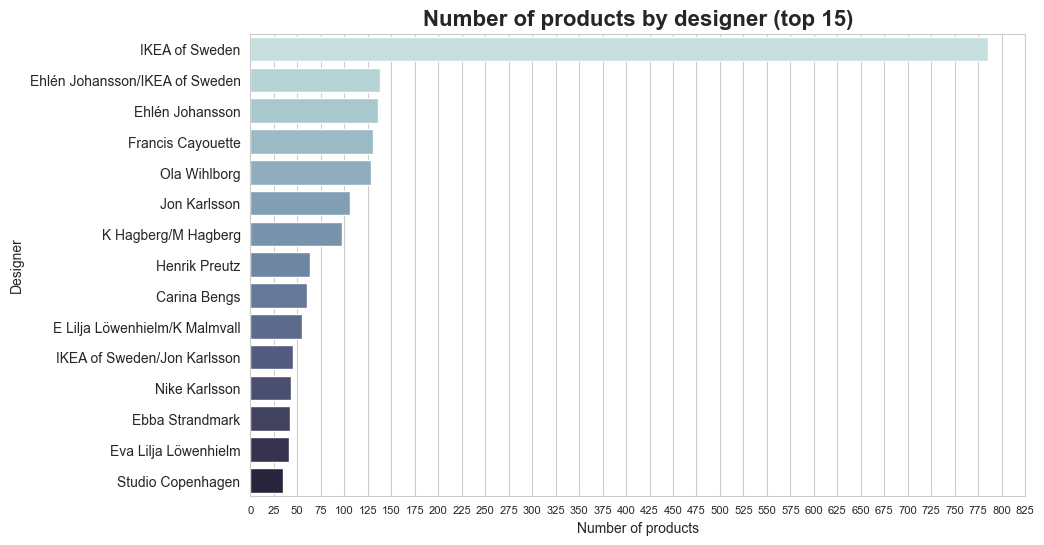

In [106]:
top_designers = df_new.designer_clean.value_counts().head(15)
plt.figure(figsize=(10,6))
sns.barplot(x=top_designers.values, 
            y=top_designers.index, 
            hue=top_designers.index, 
            dodge=False, 
            legend=False, 
            palette="ch:start=.2,rot=-.3")
plt.title("Number of products by designer (top 15)", fontsize=16, fontweight="bold")
plt.xlabel("Number of products")
plt.ylabel("Designer")
plt.xticks(range(0, 850, 25), fontsize=8)
plt.show()

In [56]:
df_new.designer_clean.value_counts().head(15)

designer_clean
IKEA of Sweden                    785
Ehlén Johansson/IKEA of Sweden    138
Ehlén Johansson                   136
Francis Cayouette                 131
Ola Wihlborg                      128
Jon Karlsson                      106
K Hagberg/M Hagberg                98
Henrik Preutz                      64
Carina Bengs                       60
E Lilja Löwenhielm/K Malmvall      55
IKEA of Sweden/Jon Karlsson        46
Nike Karlsson                      43
Ebba Strandmark                    42
Eva Lilja Löwenhielm               41
Studio Copenhagen                  35
Name: count, dtype: int64

In [57]:
median_price = df_new.groupby("designer_clean")["price"].median()
top_median_designers = median_price.sort_values(ascending=False).head(15)
top_median_designers

designer_clean
Ehlén Johansson/Fredriksson/Hilland/L Löwenhielm                   7988.0
Ebba Strandmark/Ehlén Johansson/IKEA of Sweden/Ola Wihlborg        6065.0
Ehlén Johansson/Ola Wihlborg                                       5465.0
Carl Öjerstam/J Marnell/S Lanneskog                                5370.0
J Marnell/Ola Wihlborg/S Lanneskog                                 5275.0
Henrik Preutz/IKEA of Sweden                                       4841.0
Andreas Fredriksson/Marcus Arvonen                                 4785.0
IKEA of Sweden/J Marnell/S Lanneskog                               4745.0
Ehlén Johansson/Francis Cayouette/IKEA of Sweden                   4590.0
Ehlén Johansson/Karl Malmvall                                      4565.0
Ehlén Johansson/Fredriksson/Hilland/IKEA of Sweden/L Löwenhielm    4448.0
Chris Martin/IKEA of Sweden/Ola Wihlborg                           4295.0
J Löfgren/J Pettersson/Marcus Arvonen                              4265.0
Carl Öjerstam/IKEA of S

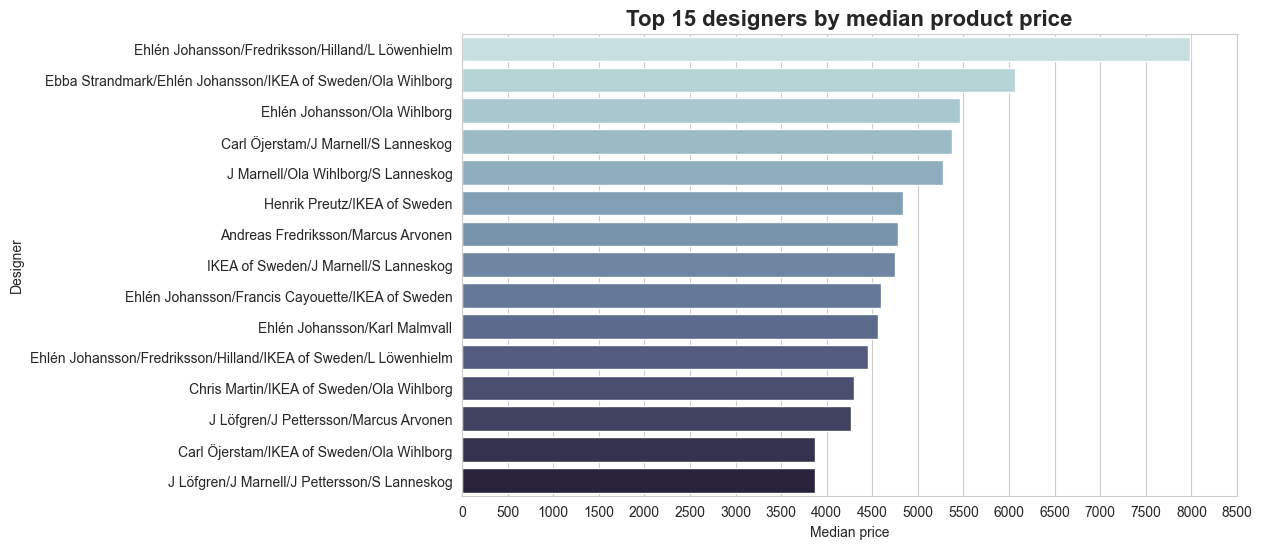

In [107]:
median_price = df_new.groupby("designer_clean")["price"].median()
top_median_designers = median_price.sort_values(ascending=False).head(15)
plt.figure(figsize=(10,6))
sns.barplot(x=top_median_designers.values, 
            y=top_median_designers.index, 
            hue=top_median_designers.index, 
            dodge=False, 
            legend=False,
            palette="ch:start=.2,rot=-.3")
plt.xlabel("Median price")
plt.ylabel("Designer")
plt.title("Top 15 designers by median product price", fontsize=16, fontweight="bold")
plt.xticks(range(0, 9000, 500))
plt.show()

In [59]:
df_new.other_colors.unique()

array(['No', 'Yes'], dtype=object)

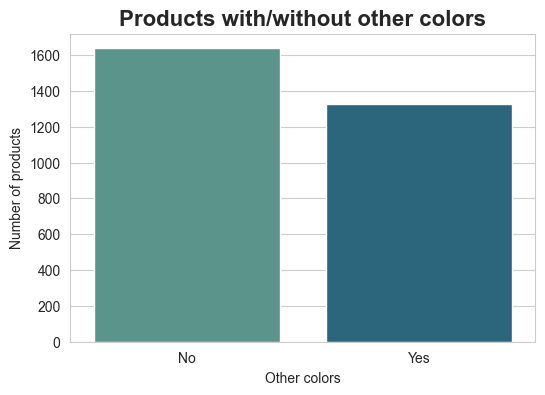

In [108]:
color_counts = df_new.other_colors.value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=color_counts.index, 
            y=color_counts.values, 
            hue=color_counts.index, 
            dodge=False, 
            legend=False,
            palette="crest")
plt.ylabel("Number of products")
plt.xlabel("Other colors")
plt.title("Products with/without other colors", fontsize=16, fontweight="bold")
plt.show()

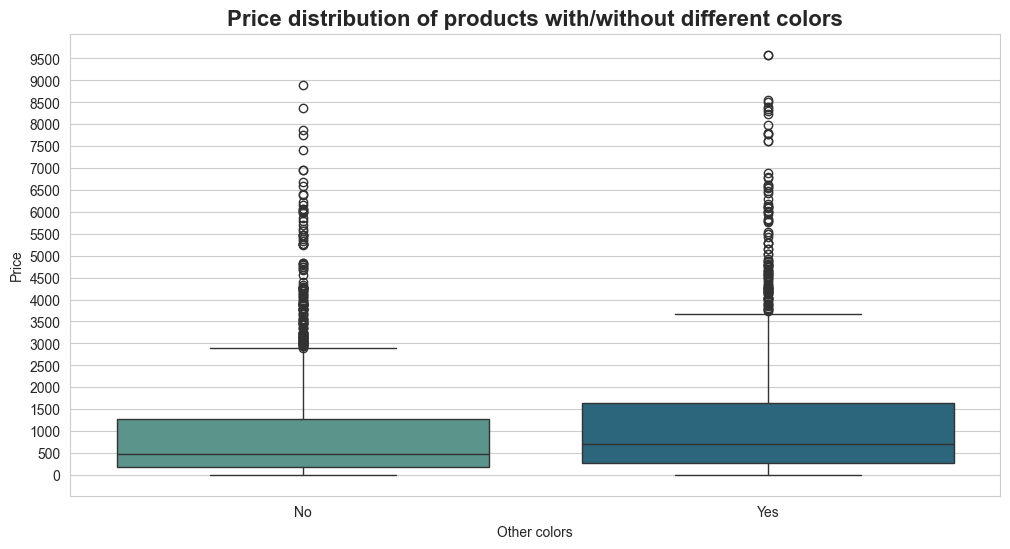

In [109]:
sns.boxplot(data=df_new, 
            x="other_colors", 
            y="price", 
            hue="other_colors", 
            dodge=False, 
            legend=False,
            palette="crest")
plt.xlabel("Other colors")
plt.ylabel("Price")
plt.title("Price distribution of products with/without different colors", fontsize=16, fontweight="bold")
plt.yticks(range(0, 10000, 500))
plt.show()

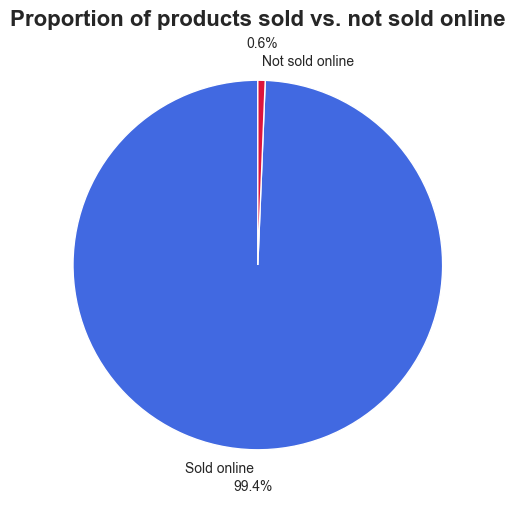

In [110]:
online_counts = df_new.sellable_online.value_counts()
online_counts.index = ["Sold online", "Not sold online"]
plt.figure(figsize=(6,6))
plt.pie(online_counts.values, 
        labels=online_counts.index, 
        autopct="%1.1f%%", 
        startangle=90,
        pctdistance=1.2,
        colors=["royalblue", "crimson"])
plt.title("Proportion of products sold vs. not sold online", fontsize=16, fontweight="bold")
plt.show()

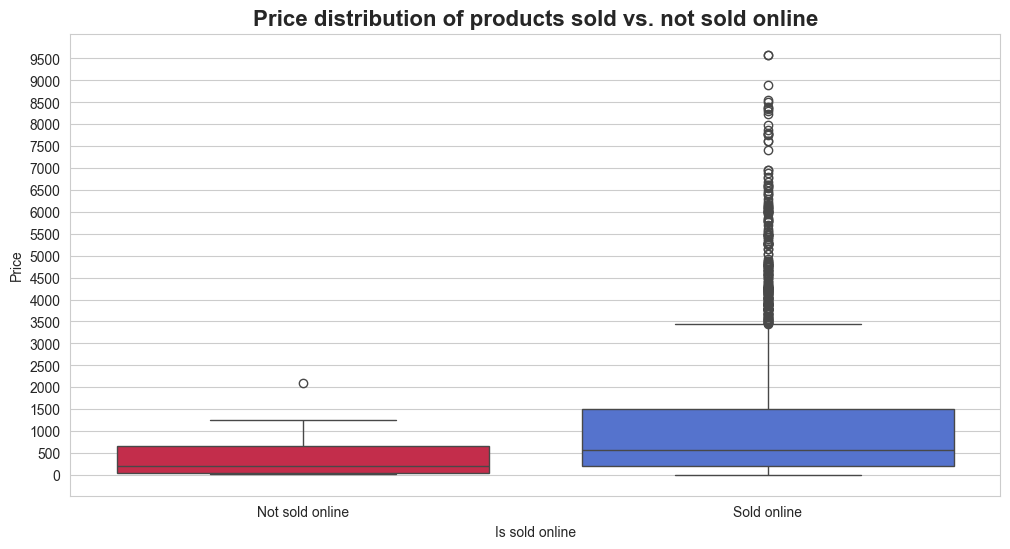

In [111]:
median_price_online = df_new.groupby("sellable_online")["price"].median()
median_price_online.index = ["Not sold online", "Sold online"]
sns.boxplot(data=df_new, 
            x="sellable_online", 
            y="price", 
            hue="sellable_online", 
            dodge=False, 
            legend=False,
            palette={True: "royalblue", False: "crimson"})
plt.xticks([0,1], ["Not sold online", "Sold online"])
plt.ylabel("Price")
plt.xlabel("Is sold online")
plt.title("Price distribution of products sold vs. not sold online", fontsize=16, fontweight="bold")
plt.yticks(range(0, 10000, 500))
plt.show()

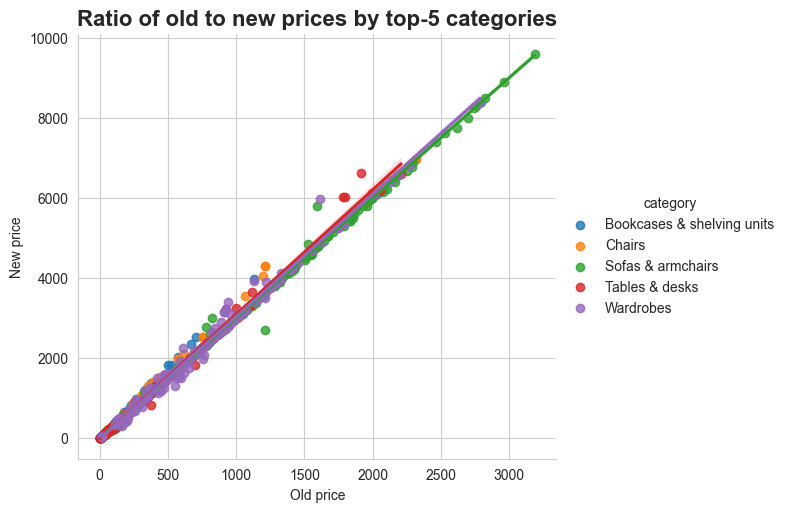

In [116]:
top5_categories = df_new['category'].value_counts().nlargest(5).index
df_top5 = df_new[df_new['category'].isin(top5_categories)]

sns.lmplot(data=df_top5, x="old_price_usd", y="price", hue="category", height=5, aspect=1.2)
plt.xlabel("Old price")
plt.ylabel("New price")
plt.title("Ratio of old to new prices by top-5 categories", fontsize=16, fontweight="bold")
plt.show()

## 🔎 Analysis and testing of statistical hypotheses

🧮 Apply logarithmic transformation to the `price` column to normalize its distribution

In [117]:
df_new["log_price"] = np.log1p(df_new["price"])

In [118]:
df_new.log_price.describe()

count    2962.000000
mean        6.216624
std         1.426821
min         1.386294
25%         5.303305
50%         6.347389
75%         7.297091
max         9.168059
Name: log_price, dtype: float64

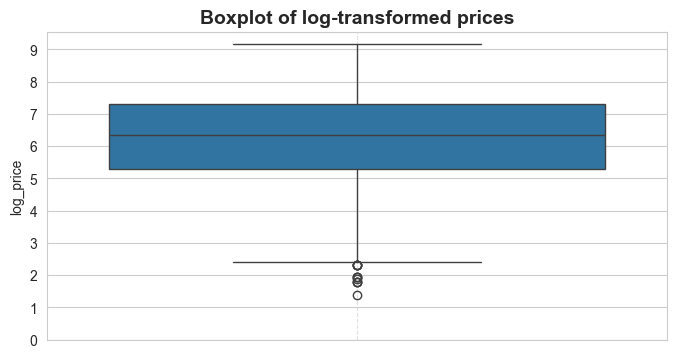

In [120]:
plt.figure(figsize=(8, 4))
sns.boxplot(df_new.log_price)
plt.title("Boxplot of log-transformed prices", fontsize=14, fontweight="bold")
plt.yticks(range(0, 10, 1))
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

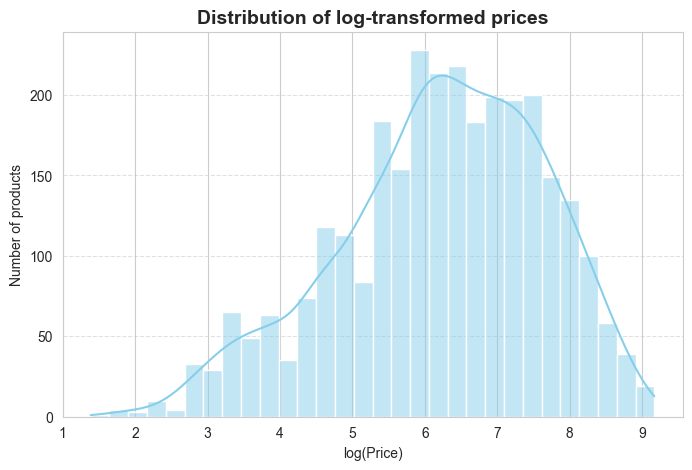

In [121]:
plt.figure(figsize=(8, 5))
sns.histplot(df_new.log_price, kde=True, color="skyblue", bins=30)
plt.title("Distribution of log-transformed prices", fontsize=14, fontweight="bold")
plt.xlabel("log(Price)", fontsize=10)
plt.ylabel("Number of products", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

📊 Bell-shaped histogram: mean and median are close, fewer outliers → distribution appears normal

👉 Thus, for the `log_price` variable, hypothesis testing methods for a normal distribution can be applied

## Hypothesis 1: "Price depends on the availability of alternative colors, but only in certain categories"

Rationale: For furniture like sofas, the availability of colors may strongly affect price, while for kitchen cabinets it may not.

- H0: The effect of `other_colors` on price is the same across all categories.  
- H1: The impact of `other_colors` on price depends on the category.

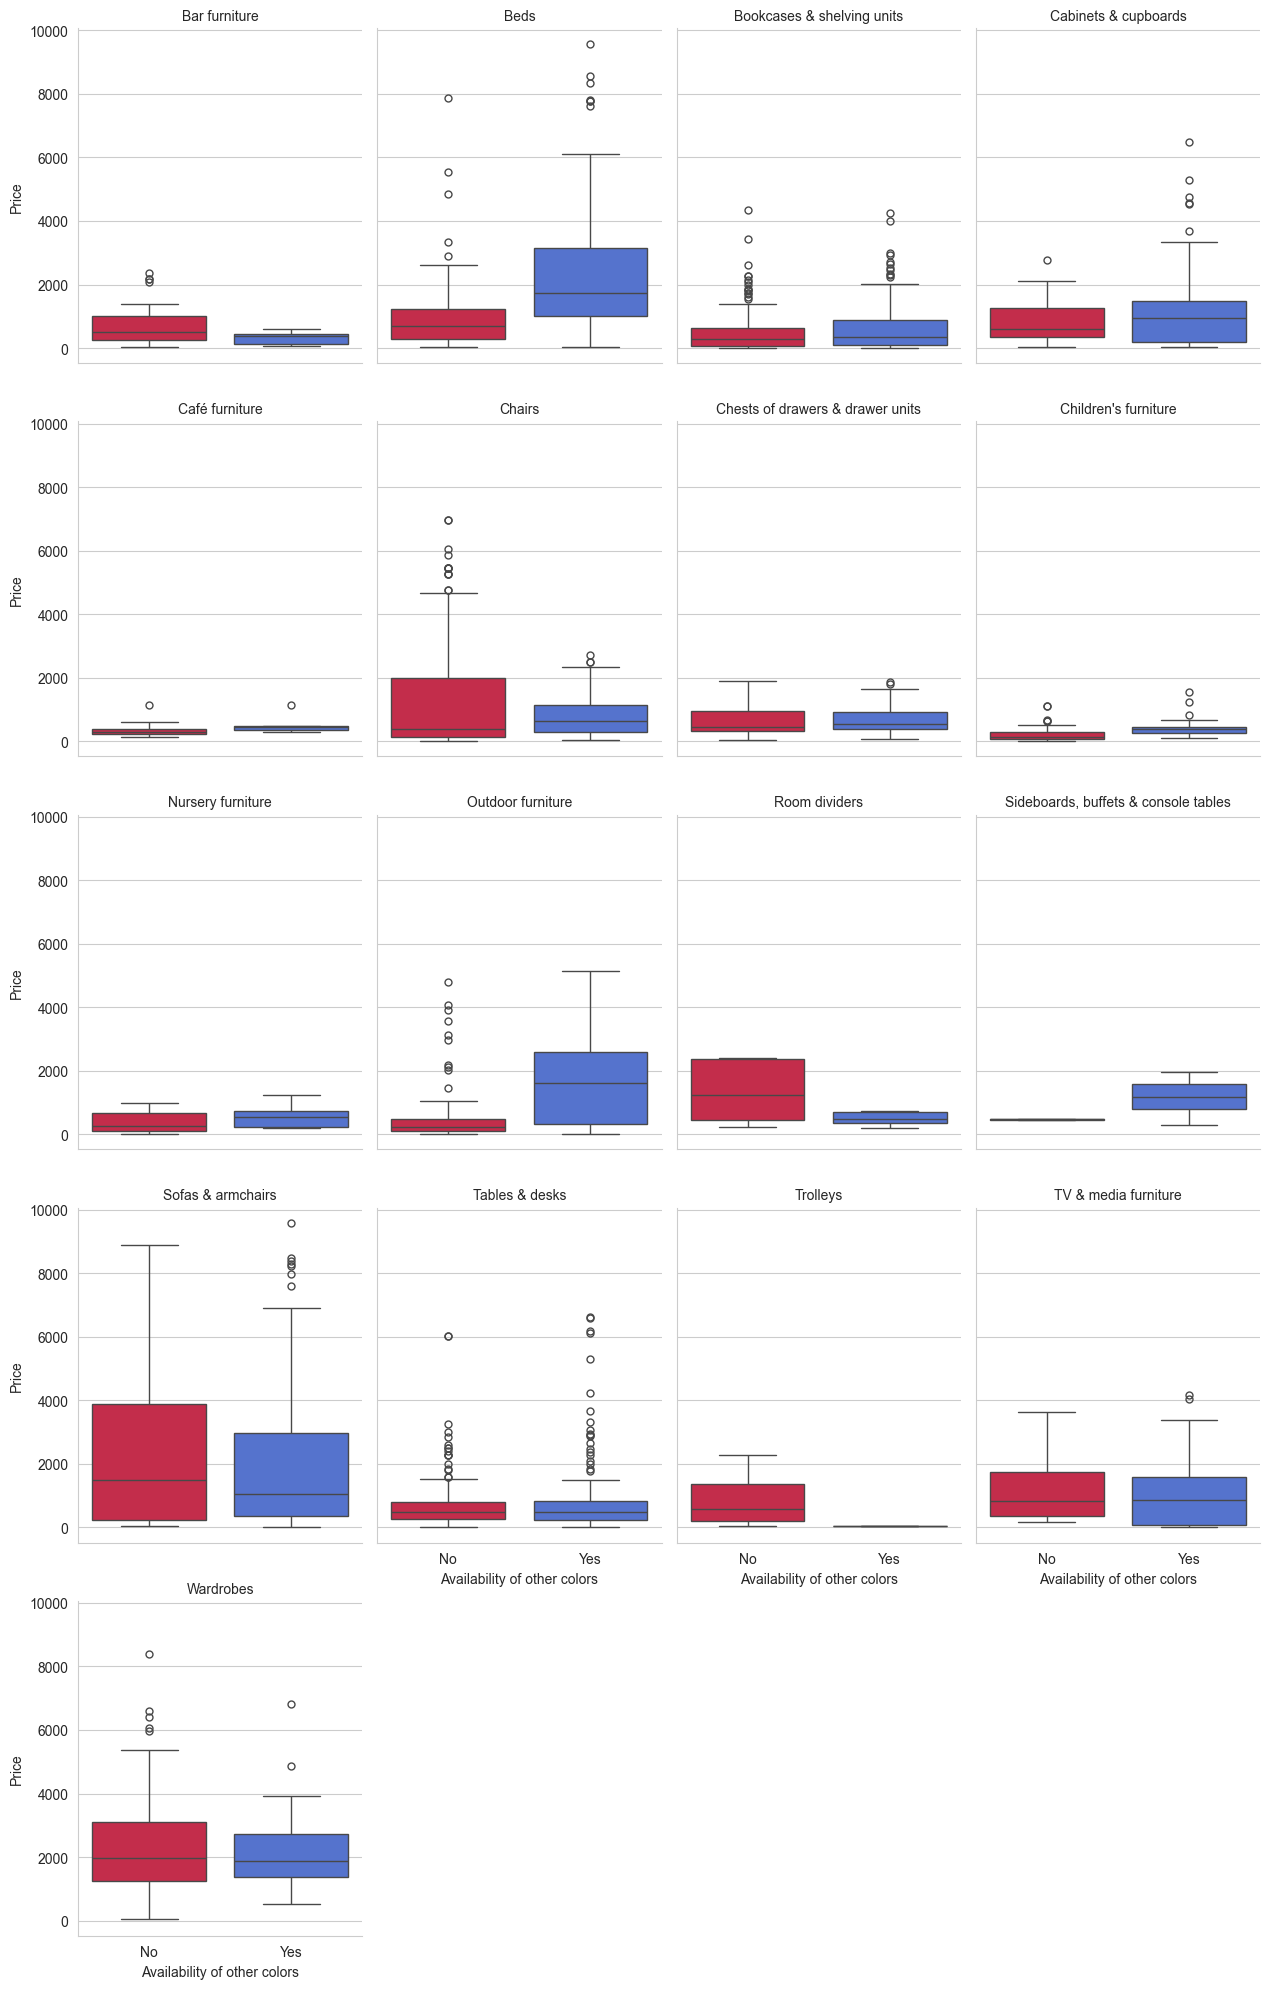

In [122]:
palette = {"Yes": "royalblue", "No": "crimson"}

g = sns.catplot(
    data=df_new,
    x="other_colors",
    y="price",
    col="category",
    kind="box",
    hue="other_colors",  
    palette=palette,
    col_wrap=4,
    height=4,
    aspect=0.8,
    dodge=False)

g.set_titles("{col_name}")
g.set_axis_labels("Availability of other colors", "Price")

plt.tight_layout()
plt.show()

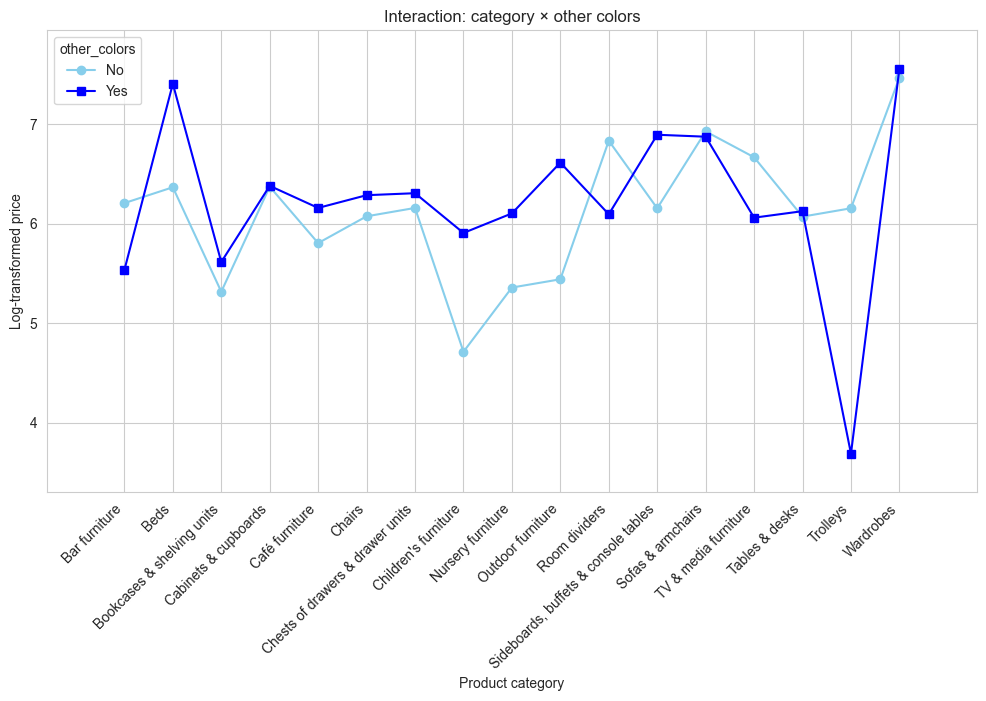

In [123]:
from statsmodels.graphics.factorplots import interaction_plot

fig = interaction_plot(
    df_new["category"],
    df_new["other_colors"],
    df_new["log_price"],
    colors=["skyblue", "blue"],
    markers=["o", "s"],
    ms=6
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Product category")
plt.ylabel("Log-transformed price")
plt.title("Interaction: category × other colors")
plt.show()

1️⃣ Statistical test: ANOVA with interaction

In [125]:
model = ols("log_price ~ C(category) * C(other_colors)", data=df_new).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table = anova_table.rename(columns={
    "sum_sq": "Sum of squares",
    "df": "Degrees of freedom",
    "F": "F-statistics",
    "PR(>F)": "p-value"
})

anova_table = anova_table.rename({
    "C(category)": "Category",
    "C(other_colors)": "Alternative  colors",
    "C(category):C(other_colors)": "Interaction"
})

anova_table.loc[:, anova_table.columns != "p-value"] = anova_table.loc[:, anova_table.columns != "p-value"].round(3)

# Convert p-value to scientific notation (if very small)
anova_table["p-value"] = anova_table["p-value"].apply(lambda x: f"{x:.2e}" if x < 0.001 else f"{x:.3f}")

anova_table

,Sum of squares,Degrees of freedom,F-statistics,p-value
Category,1043.968,16.0,40.097,1.95e-113
Alternative colors,56.463,1.0,34.698,4.29e-09
Interaction,125.878,16.0,4.835,6.97e-10
Residual,4764.631,2928.0,NaN,nan


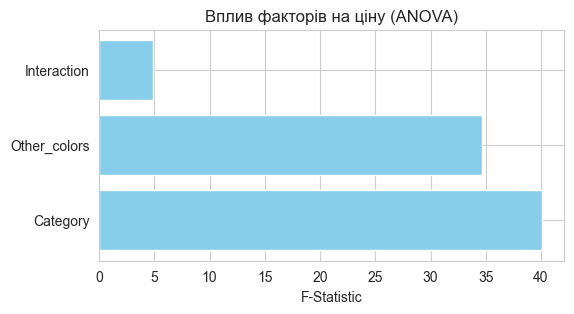

In [72]:
f_values = [40.1, 34.7, 4.83]
factors = ["Category", "Other_colors", "Interaction"]

plt.figure(figsize=(6,3))
plt.barh(factors, f_values, color="skyblue")
plt.xlabel("F-statistics")
plt.title("Effect of factors on price (ANOVA)")
plt.show()

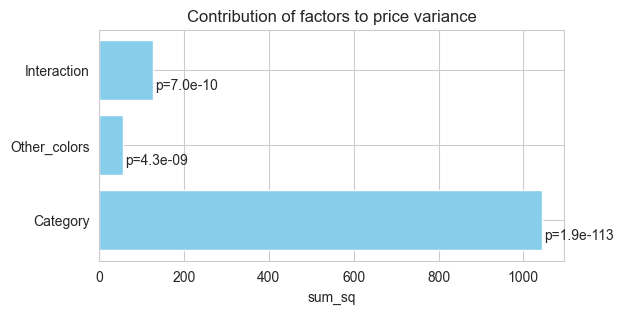

In [126]:
factors = ["Category", "Other_colors", "Interaction"]
sum_sq = [1043.97, 56.46, 125.88]
p_values = [1.95e-113, 4.29e-09, 6.97e-10]

colors = ["skyblue" if p<0.001 else "lightgrey" for p in p_values]

plt.figure(figsize=(6,3))
bars = plt.barh(factors, sum_sq, color=colors)
for bar, p in zip(bars, p_values):
    plt.text(bar.get_width()+5, bar.get_y()+0.2, f"p={p:.1e}", va="center")
plt.xlabel("sum_sq")
plt.title("Contribution of factors to price variance")
plt.show()


Two-way ANOVA showed that both `category` (p < 0.001) and `other_colors` (p < 0.001) significantly affect price.  
Moreover, the interaction `category × other_colors` is also significant (p < 0.001), confirming the hypothesis that the impact of alternative colors on price varies across categories.  
Using `log_price` helped reduce the influence of outliers.

2️⃣ Statistical test: T-test / Mann-Whitney within categories

In [74]:
results = []

for cat in df_new["category"].unique():
    data_cat = df_new[df_new["category"] == cat]
    
    yes_prices = data_cat[data_cat["other_colors"]=="Yes"]["log_price"]
    no_prices = data_cat[data_cat["other_colors"]=="No"]["log_price"]
    
    if len(yes_prices) > 2 and len(no_prices) > 2:
        stat_yes, p_yes = shapiro(yes_prices)
        stat_no, p_no = shapiro(no_prices)
        
        if p_yes > 0.05 and p_no > 0.05:
            stat, pval = ttest_ind(yes_prices, no_prices, equal_var=False)
        else:
            stat, pval = mannwhitneyu(yes_prices, no_prices)
        
        results.append((cat, stat, pval))

results_df = pd.DataFrame(results, columns=["Category", "Statistic", "p-value"])
results_df["Statistic"] = results_df["Statistic"].round(3)
results_df["p-value"] = results_df["p-value"].apply(lambda x: f"{x:.2e}" if x < 0.001 else f"{x:.3f}")

results_df

,Category,Statistic,p-value
0,Bar furniture,-1.571,0.176
1,Beds,8151.500,8.23e-11
2,Bookcases & shelving units,40639.000,0.024
3,Cabinets & cupboards,3600.000,0.335
4,Café furniture,1.244,0.252
5,Chairs,17192.000,0.410
6,Chests of drawers & drawer units,1704.500,0.333
7,Children's furniture,1264.500,5.21e-06
8,Nursery furniture,1.756,0.096
9,Outdoor furniture,6686.500,8.29e-08


A significant effect of `other_colors` is observed in the categories: Beds, Children’s furniture, Outdoor furniture, and Bookcases & shelving units.  
In other categories (e.g., Tables & desks, Sofas & armchairs), no statistically significant effect was found (p ≥ 0.05).

## Hypothesis 2: "Some designers systematically create more expensive products"

Rationale: Certain designers may be associated with "premium" product lines, regardless of category or furniture size.

- H0: The mean price does not depend on the designer.  
- H1: At least one designer has a significantly different mean price compared to others.

In [75]:
df_new.head()

,name,category,price,sellable_online,other_colors,short_description,depth,height,width,designer_clean,old_price_usd,log_price
0,FREKVENS,Bar furniture,265.0,True,No,"Bar table, in/outdoor, 51x51 cm",47.0,99.0,51.0,Nicholai Wiig Hansen,88.110326,5.583496
1,NORDVIKEN,Bar furniture,995.0,False,No,"Bar table, 140x80 cm",47.0,105.0,80.0,Francis Cayouette,330.829336,6.903747
2,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,False,No,Bar table and 4 bar stools,47.0,102.0,48.0,Francis Cayouette,696.570309,7.647786
3,STIG,Bar furniture,69.0,True,Yes,"Bar stool with backrest, 74 cm",50.0,100.0,60.0,Henrik Preutz,22.941934,4.248495
4,NORBERG,Bar furniture,225.0,True,No,"Wall-mounted drop-leaf table, ...",60.0,43.0,74.0,Marcus Arvonen,74.810654,5.420535


In [127]:
# Select the top 15 designers by number of products

top_designers = df_new["designer_clean"].value_counts().head(15).index
df_top = df_new[df_new["designer_clean"].isin(top_designers)]

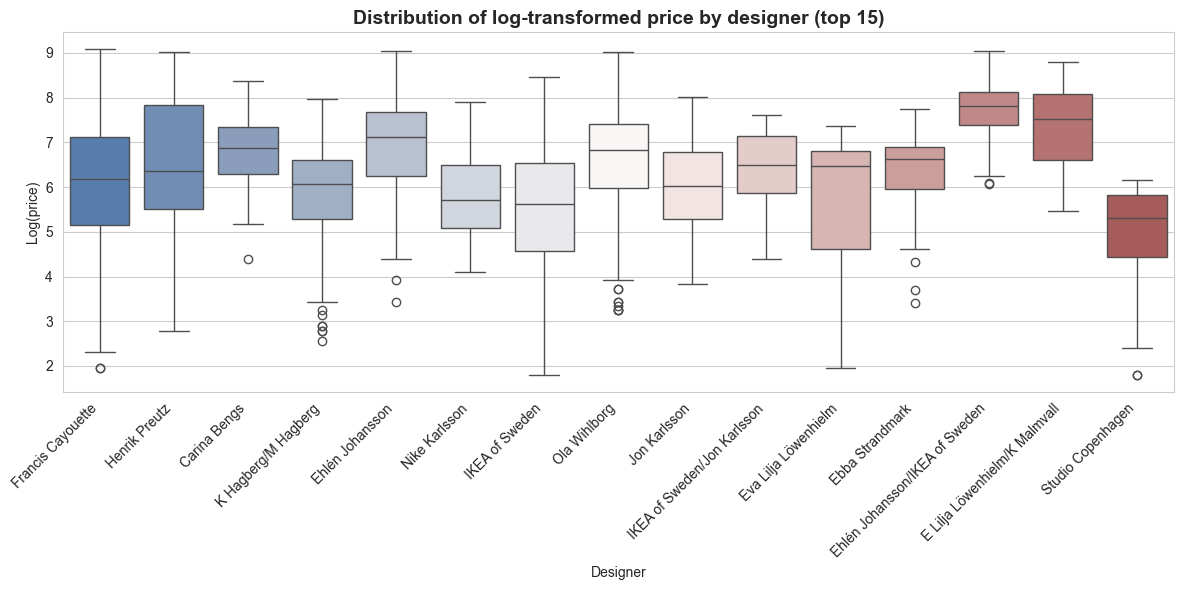

In [128]:
sns.boxplot(
    data=df_top,
    x="designer_clean",
    y="log_price",
    palette="vlag",
    hue="designer_clean", 
    dodge=False, 
    legend=False)
plt.title("Distribution of log-transformed price by designer (top 15)", fontsize=14, fontweight="bold")
plt.xlabel("Designer")
plt.ylabel("Log(price)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/var/folders/j7/7h_cjxwd53bgn6302v2jdgh80000gn/T/ipykernel_67241/700453189.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


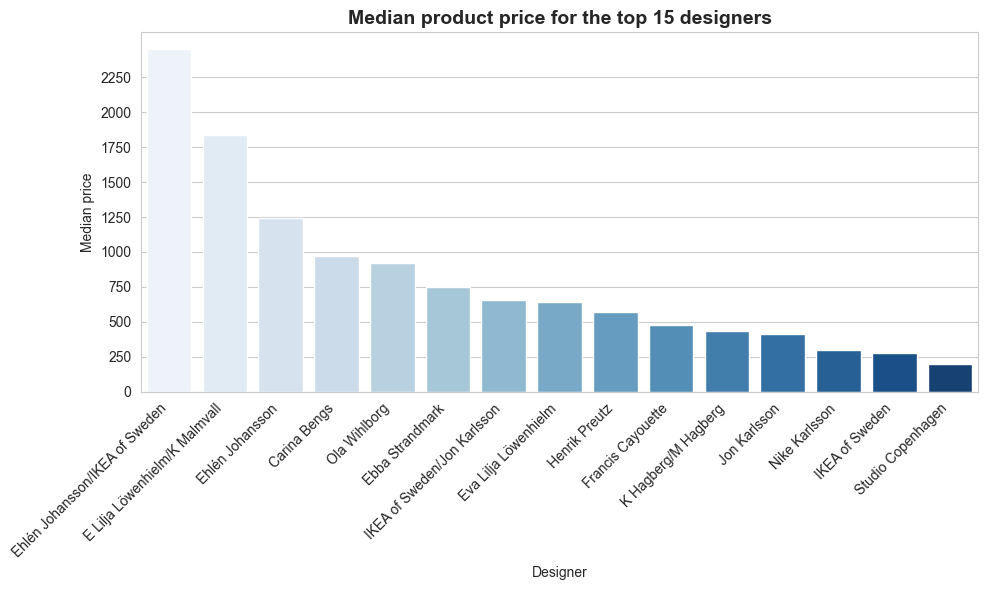

In [129]:
median_prices = df_top.groupby("designer_clean")["price"].median().sort_values(ascending=False)
median_prices = median_prices.reset_index()

plt.figure(figsize=(10,6))
sns.barplot(
    data=median_prices,
    x="designer_clean",
    y="price",
    palette="Blues"
)
plt.xticks(rotation=45, ha="right")
plt.yticks(range(0, 2500, 250))
plt.xlabel("Designer")
plt.ylabel("Median price")
plt.title("Median product price for the top 15 designers", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

1️⃣ Statistical test: ANOVA

In [132]:
model = ols('log_price ~ C(designer_clean)', data=df_top).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table = anova_table.rename(columns={
    "sum_sq": "Sum of squares",  
    "df": "Degrees of freedom", 
    "F": "F-statistic",
    "PR(>F)": "p-value"

})

anova_table = anova_table.rename({
    "C(designer_clean)": "Designer"
})

anova_table.loc[:, anova_table.columns != "p-value"] = anova_table.loc[:, anova_table.columns != "p-value"].round(3)

# Convert p-value to scientific notation (if very small)
anova_table["p-value"] = anova_table["p-value"].apply(lambda x: f"{x:.2e}" if x < 0.001 else f"{x:.3f}")

anova_table

,Sum of squares,Degrees of freedom,F-statistic,p-value
Designer,999.386,14.0,44.81,5.45e-107
Residual,3015.674,1893.0,NaN,nan


Conclusion:  
According to the ANOVA results, F-statistic = 44.81, which is very high, indicating that the portion of price variation explained by the designer is substantial compared to random fluctuations.  
With p-value < 0.05, the null hypothesis is rejected, meaning there are statistically significant differences in mean prices between designers.

2️⃣ Statistical test: Tukey HSD

In [133]:
tukey = pairwise_tukeyhsd(
    endog=df_top["log_price"],       
    groups=df_top["designer_clean"], 
    alpha=0.05)

tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
tukey_df.head(10)

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Carina Bengs,E Lilja Löwenhielm/K Malmvall,0.6059,0.3900,-0.1943,1.4060,False
1,Carina Bengs,Ebba Strandmark,-0.5071,0.8004,-1.3694,0.3552,False
2,Carina Bengs,Ehlén Johansson,0.1306,1.0000,-0.5337,0.7948,False
3,Carina Bengs,Ehlén Johansson/IKEA of Sweden,0.9215,0.0002,0.2587,1.5843,True
4,Carina Bengs,Eva Lilja Löwenhielm,-1.0453,0.0041,-1.9138,-0.1769,True
5,Carina Bengs,Francis Cayouette,-0.9056,0.0004,-1.5737,-0.2375,True
6,Carina Bengs,Henrik Preutz,-0.3021,0.9922,-1.0723,0.4681,False
7,Carina Bengs,IKEA of Sweden,-1.3089,0.0000,-1.8830,-0.7348,True
8,Carina Bengs,IKEA of Sweden/Jon Karlsson,-0.4617,0.8695,-1.3017,0.3782,False
9,Carina Bengs,Jon Karlsson,-0.8399,0.0036,-1.5324,-0.1475,True


In [134]:
sig_tukey = tukey_df[tukey_df.reject == True].copy()

sig_tukey["direction"] = sig_tukey.meandiff.apply(lambda x: "group1 more expensive" if x > 0 else "group1 less expensive")

sig_tukey.meandiff = sig_tukey.meandiff.round(2)
sig_tukey["p-adj"] = sig_tukey["p-adj"].apply(lambda x: '{:.3e}'.format(x))
sig_tukey.lower = sig_tukey.lower.round(2)
sig_tukey.upper = sig_tukey.upper.round(2)

report_table = sig_tukey[['group1', 'group2', 'meandiff', 'lower', 'upper', 'p-adj', 'direction']]

report_table = report_table.sort_values(by='meandiff', ascending=False).reset_index(drop=True)

report_table

,group1,group2,meandiff,lower,upper,p-adj,direction
0,Ebba Strandmark,Ehlén Johansson/IKEA of Sweden,1.43,0.67,2.18,0.000e+00,group1 more expensive
1,IKEA of Sweden,Ola Wihlborg,1.11,0.71,1.52,0.000e+00,group1 more expensive
2,Carina Bengs,Ehlén Johansson/IKEA of Sweden,0.92,0.26,1.58,2.000e-04,group1 more expensive
3,IKEA of Sweden,IKEA of Sweden/Jon Karlsson,0.85,0.20,1.50,1.000e-03,group1 more expensive
4,Eva Lilja Löwenhielm,Ola Wihlborg,0.85,0.08,1.62,1.480e-02,group1 more expensive
5,K Hagberg/M Hagberg,Ola Wihlborg,0.83,0.25,1.40,1.000e-04,group1 more expensive
6,Nike Karlsson,Ola Wihlborg,0.81,0.05,1.56,2.370e-02,group1 more expensive
7,Ehlén Johansson,Ehlén Johansson/IKEA of Sweden,0.79,0.27,1.31,0.000e+00,group1 more expensive
8,Francis Cayouette,Ola Wihlborg,0.71,0.18,1.24,6.000e-04,group1 more expensive
9,Jon Karlsson,Ola Wihlborg,0.64,0.08,1.21,8.900e-03,group1 more expensive


In [136]:
# launching Tukey HSD
tukey = pairwise_tukeyhsd(
    endog=df_top["log_price"],       
    groups=df_top["designer_clean"], 
    alpha=0.05)


tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

sig_tukey = tukey_df[tukey_df['reject'] == True].copy()


sig_tukey['Direction'] = sig_tukey['meandiff'].apply(lambda x: 'Designer 1 more expensive' if x > 0 else 'Designer 1 less expensive')


sig_tukey['Median difference'] = sig_tukey['meandiff'].round(2)
sig_tukey['Lower bound'] = sig_tukey['lower'].round(2)
sig_tukey['Upper bound'] = sig_tukey['upper'].round(2)
sig_tukey['p-value'] = sig_tukey['p-adj'].apply(lambda x: f"{float(x):.1e}")


report_table = sig_tukey[['group1', 'group2', 'Median difference', 'Lower bound', 'Upper bound', 'p-value', 'Direction']]
report_table = report_table.rename(columns={'group1':'Designer 1', 'group2':'Designer 2'})

report_table['abs_diff'] = report_table['Median difference'].abs()
report_table = report_table.sort_values(by='abs_diff', ascending=False).head(15)  # топ 15
report_table = report_table.drop(columns='abs_diff').reset_index(drop=True)

report_table


,Designer 1,Designer 2,Median difference,Lower bound,Upper bound,p-value,Direction
0,Ehlén Johansson/IKEA of Sweden,Studio Copenhagen,-2.90,-3.71,-2.09,0.0e+00,Designer 1 less expensive
1,E Lilja Löwenhielm/K Malmvall,Studio Copenhagen,-2.58,-3.51,-1.66,0.0e+00,Designer 1 less expensive
2,Ehlén Johansson/IKEA of Sweden,IKEA of Sweden,-2.23,-2.63,-1.83,0.0e+00,Designer 1 less expensive
3,Ehlén Johansson,Studio Copenhagen,-2.11,-2.92,-1.30,0.0e+00,Designer 1 less expensive
4,Carina Bengs,Studio Copenhagen,-1.98,-2.89,-1.07,0.0e+00,Designer 1 less expensive
5,Ehlén Johansson/IKEA of Sweden,Eva Lilja Löwenhielm,-1.97,-2.73,-1.20,0.0e+00,Designer 1 less expensive
6,Ehlén Johansson/IKEA of Sweden,K Hagberg/M Hagberg,-1.94,-2.51,-1.38,0.0e+00,Designer 1 less expensive
7,Ehlén Johansson/IKEA of Sweden,Nike Karlsson,-1.92,-2.67,-1.17,0.0e+00,Designer 1 less expensive
8,E Lilja Löwenhielm/K Malmvall,IKEA of Sweden,-1.91,-2.51,-1.32,0.0e+00,Designer 1 less expensive
9,Ehlén Johansson/IKEA of Sweden,Francis Cayouette,-1.83,-2.35,-1.30,0.0e+00,Designer 1 less expensive


Conclusion:  
Tukey HSD revealed significant differences in mean prices among the top designers.  
Some designers consistently produce more expensive products (e.g., Ebba Strandmark, IKEA of Sweden), while others are less expensive (E Lilja Löwenhielm/K Malmvall, Studio Copenhagen).  
The p-values are very low, indicating that these differences are statistically significant.  
Product price is largely influenced by the designer, making this feature valuable for price prediction models.

## 🤖 Machine Learning

In [148]:
# Creating median-based features for categories and designers, converting `other_colors` to a binary feature

median_for_cat = df_new.groupby(["category"])["log_price"].median()
median_for_dsgn = df_new.groupby(["designer_clean"])["log_price"].median()

df_new["category_med_price"] = df_new["category"].map(median_for_cat)
df_new["designer_med_price"] = df_new["designer_clean"].map(median_for_dsgn)

df_new["other_colors_binary"] = df_new["other_colors"].map({"No": 0, "Yes": 1})

In [149]:
# Selecting the target variable and features

Y = df_new["log_price"]
X = df_new[["depth", "height", "width", "category_med_price", "designer_med_price", "other_colors_binary"]]


In [150]:
# Splitting data into train and test sets (80/20)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [151]:
# Preparing features for the models

numeric_transf = Pipeline([
    ("scaler", StandardScaler())
])

col_prepr = ColumnTransformer(transformers=[
    ("numeric", numeric_transf, 
        ["depth", "width", "height", "category_med_price", "designer_med_price"]
    )])

In [152]:
# Function to select the best regression model among several options based on accuracy metrics

def getBestRegressor(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    models = [
        LinearRegression(),
        LassoCV(),
        RidgeCV(),
        SVR(kernel="linear"),
        KNeighborsRegressor(n_neighbors=16),
        DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor()
    ]

    results = []

    for model in models:
        name = type(model).__name__ 
        model.fit(X_train, Y_train)
        pred = model.predict(X_test)

        results.append({
            "Model": name,
            "R2": r2_score(Y_test, pred),
            "MAE": mean_absolute_error(Y_test, pred),
            "RMSE": np.sqrt(mean_squared_error(Y_test, pred))
        })

    return pd.DataFrame(results).sort_values("R2", ascending=False).reset_index(drop=True)


best_df = getBestRegressor(X, Y)

slide_table = best_df.copy()


slide_table["R2"] = (slide_table["R2"] * 100).round(1).astype(str) + "%"
slide_table["MAE"] = slide_table["MAE"].round(0)
slide_table["RMSE"] = slide_table["RMSE"].round(0)

slide_table

,Model,R2,MAE,RMSE
0,RandomForestRegressor,81.6%,0.0,1.0
1,GradientBoostingRegressor,74.5%,1.0,1.0
2,DecisionTreeRegressor,70.9%,1.0,1.0
3,KNeighborsRegressor,66.7%,1.0,1.0
4,SVR,54.6%,1.0,1.0
5,RidgeCV,54.3%,1.0,1.0
6,LinearRegression,54.3%,1.0,1.0
7,LassoCV,54.1%,1.0,1.0


From the results of the model selection function, it is clear that RandomForestRegressor performed best.  
Accordingly, it has the lowest absolute and squared errors.

To find the best hyperparameters for the RandomForestRegressor, GridSearchCV will be used

In [153]:
# Grid Search applied only to the best model

best_model_name = best_df.iloc[0]["Model"]

model_map = {
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(max_depth=10, random_state=42),
    "SVR": SVR(kernel="linear"),
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=16),
    "LinearRegression": LinearRegression(),
    "RidgeCV": RidgeCV(),
    "LassoCV": LassoCV()
}

best_model = model_map.get(best_model_name)

if best_model_name in ["RandomForestRegressor", "GradientBoostingRegressor", "DecisionTreeRegressor"]:
    param_grid = {"n_estimators":[50,100,200], "max_depth":[8,12,16]}
else:
    param_grid = {} 

if param_grid:
    grid = GridSearchCV(best_model, param_grid, cv=10)
    grid.fit(X_train, Y_train)
    best_estimator = grid.best_estimator_
    best_params = grid.best_params_
else:
    best_estimator = best_model
    best_estimator.fit(X_train, Y_train)
    best_params = "No hyperparameters to tune"

Y_pred = best_estimator.predict(X_test)


print("⚡ Best hyperparameters for the selected model")
print("-" * 40)
if isinstance(best_params, dict):
    for param, value in best_params.items():
        print(f"{param} : {value}")
else:
    print(best_params)

⚡ Best hyperparameters for the selected model
----------------------------------------
max_depth : 16
n_estimators : 200


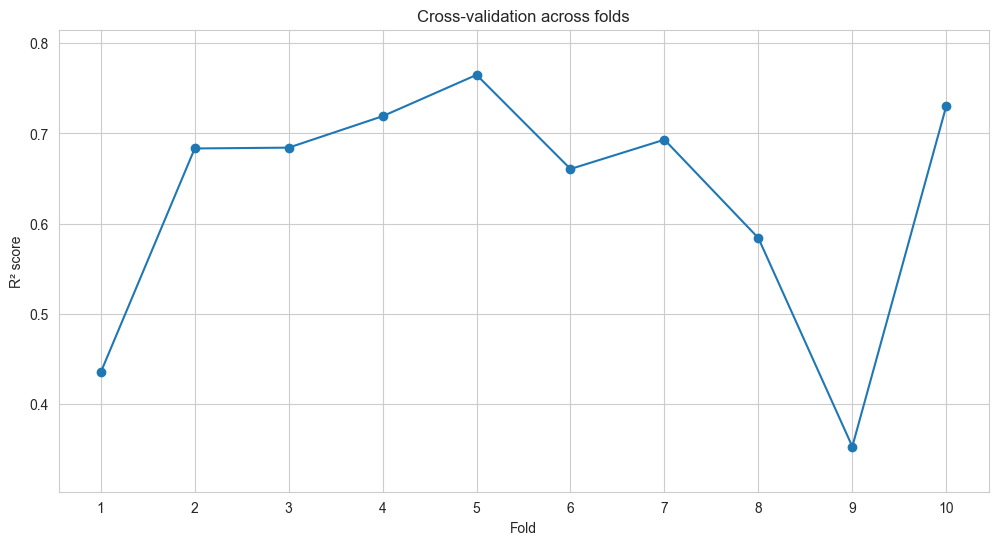

In [154]:
# Cross-validation for the best model
cv_scores = cross_val_score(grid.best_estimator_, X, Y, cv=10)

# Cross-validation visualization
plt.plot(range(1, len(cv_scores)+1), cv_scores, marker="o")  
plt.title("Cross-validation across folds")
plt.ylabel("R² score")
plt.xlabel("Fold")
plt.xticks(range(1, len(cv_scores)+1))
plt.ylim(cv_scores.min() - 0.05, cv_scores.max() + 0.05)
plt.show()

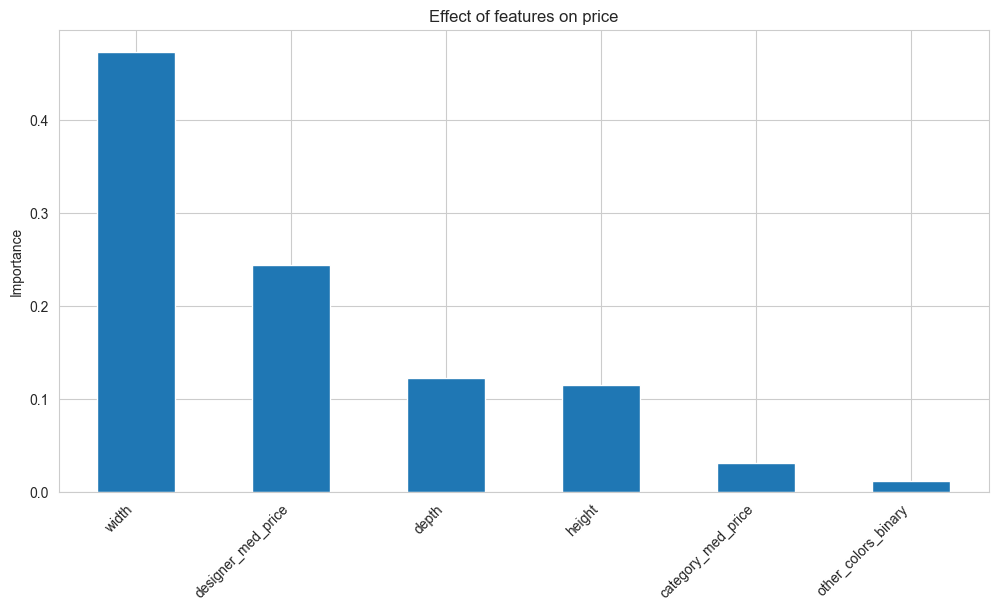

In [155]:
# Feature importance plot

fi = pd.Series(grid.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure()
fi.plot(kind="bar")
plt.title("Effect of features on price")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha="right")
plt.show()

In [163]:
print("Results of tuning the best model")
print(f"R²  : {r2_score(Y_test, Y_pred):.3f}")
print(f"MAE : {mean_absolute_error(Y_test, Y_pred):.0f}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_test, Y_pred)):.0f}")

Results of tuning the best model
R²  : 0.815
MAE : 0
RMSE: 1


The RandomForestRegressor model with hyperparameters `max_depth=50` and `n_estimators=100` showed the best results among the tested combinations.  
The average cross-validation score was 0.80, and on the test data the model achieved R² = 0.81, indicating high predictive performance.  
The most influential features on price are product width and the designer's median price, which aligns with business logic — physical dimensions and brand largely determine the product's value.

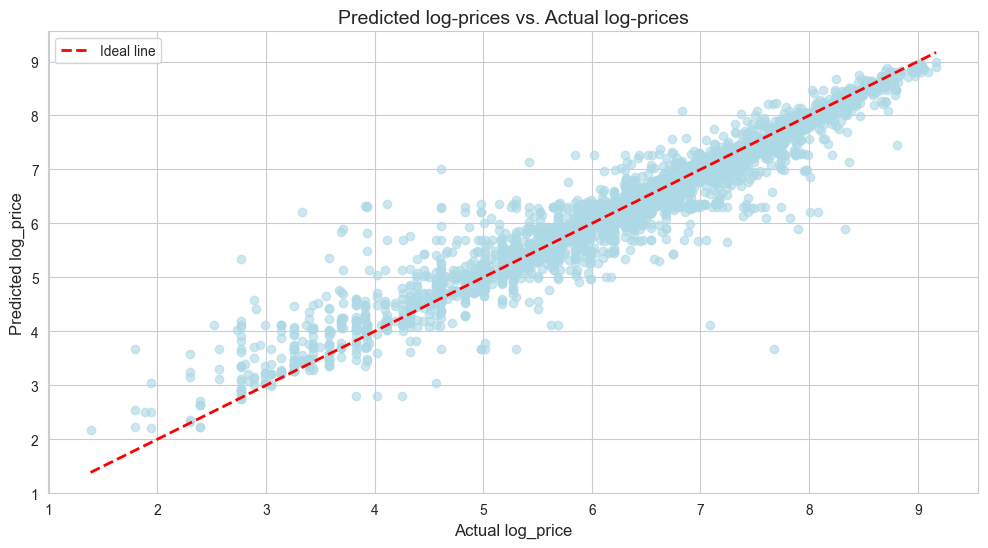

In [159]:
y_pred = grid.best_estimator_.predict(X)

plt.scatter(Y, y_pred, color="lightblue", alpha=0.6)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color="red", linewidth=2, label="Ideal line", linestyle="--")
plt.title("Predicted log-prices vs. Actual log-prices", fontsize=14)
plt.xlabel("Actual log_price", fontsize=12)
plt.ylabel("Predicted log_price", fontsize=12)
plt.legend()
plt.show()

## ✅ Results

This project explored the key drivers of furniture prices using exploratory data analysis, statistical testing, and machine learning models.
After data cleaning and feature engineering, a RandomForestRegressor demonstrated the best performance among the tested models, achieving R² = 0.815 on the test set, indicating a strong predictive capability.

Exploratory analysis revealed a highly skewed price distribution with significant outliers, especially in popular categories. Applying a logarithmic transformation to the target variable stabilized the distribution, reduced the influence of extreme values, and improved the suitability of the data for statistical tests and modeling.

Statistical hypothesis testing confirmed that:

The effect of additional color options on price depends on the product category, validating the first hypothesis.

Designers differ significantly in terms of price levels, confirming that certain designers are systematically associated with more expensive products.

Feature importance analysis showed that physical dimensions, particularly product width, and designer-related features (median designer price) play a dominant role in price prediction. Category-level features and the presence of alternative colors contribute less but still add explanatory value.

Despite strong accuracy metrics, the model exhibits some instability, suggesting sensitivity to data distribution and feature representation. This indicates potential for further improvement through advanced feature engineering, such as richer designer representations, interaction features, or additional product attributes.

Overall, the results align well with business intuition: furniture prices are primarily driven by size and brand/design identity, while secondary characteristics refine the final price. The findings highlight both the strengths of the current approach and clear directions for future model enhancement.